# Feature Extraction using CNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import cv2
import os

In [2]:
np.random.seed(42)

In [3]:
#Image path
img_path = '../data/box_img/'

#label 
label = pd.read_csv('../data/Standard.csv')['Thickness']

In [4]:
for i in range(127):
    Top = np.array(cv2.imread(img_path + 'Top/' + 'Top_' + str(i) + '.jpg'))
    Bot = np.array(cv2.imread(img_path + 'Bot/' + 'Bot_' + str(i) + '.jpg'))
    cat = np.concatenate((Top, Bot), axis = 1)
    cv2.imwrite(img_path + 'Cat/' + 'cat_' + str(i) + '.jpg', cat)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_path, label, transform = None):
        self.img_path = img_path
        self.label = label
        self.transform = transform
        
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + 'Cat/' + 'cat_' + str(idx) + '.jpg')
        label = self.label[idx]
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label)
            
        return img, label
            
#Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

#Dataset
dataset = CustomDataset(img_path, label, transform = transform)

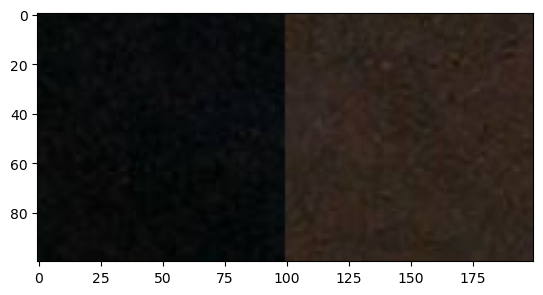

In [6]:
#show image
plt.imshow(dataset[0][0].permute(1, 2, 0))

In [7]:
#split train, test
test_idx = pd.read_csv('../data/test_index.csv')
test_idx = test_idx['test_index'].values
test_idx

array([ 26, 111,  81,  55,  44,  96,  80, 125, 114,  62,  45,   4,  18,
        95,  36,  94,  19, 120,  10,  40,  11,  98, 104,  77,   0,  78,
        68,  69,  12,  42,  31,  27,  24,  93, 110,  91,  15,  76,  22],
      dtype=int64)

In [8]:
test_dataset = torch.utils.data.Subset(dataset, test_idx)
train_dataset = torch.utils.data.Subset(dataset, list(set(range(len(dataset))) - set(test_idx)))

In [9]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [10]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 100, 200])

In [11]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)
    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [12]:
model = CNN()

epoch: 1, train_loss: 4981.1092, test_loss: 8923.9849
epoch: 2, train_loss: 802.8606, test_loss: 8093.0601
epoch: 3, train_loss: 504.4568, test_loss: 7246.3337
epoch: 4, train_loss: 230.4705, test_loss: 5580.7024
epoch: 5, train_loss: 240.6286, test_loss: 4007.9634
epoch: 6, train_loss: 284.6101, test_loss: 2529.0231
epoch: 7, train_loss: 358.8565, test_loss: 1681.0717
epoch: 8, train_loss: 157.2359, test_loss: 1604.7711
epoch: 9, train_loss: 206.0343, test_loss: 1479.1368
epoch: 10, train_loss: 202.9890, test_loss: 1218.0266
epoch: 11, train_loss: 182.4280, test_loss: 997.7950
epoch: 12, train_loss: 240.6889, test_loss: 977.3500
epoch: 13, train_loss: 281.4644, test_loss: 1205.9439
epoch: 14, train_loss: 184.1036, test_loss: 1524.1229
epoch: 15, train_loss: 187.5953, test_loss: 1438.0962
epoch: 16, train_loss: 191.4296, test_loss: 1129.4875
epoch: 17, train_loss: 180.2310, test_loss: 954.6064
epoch: 18, train_loss: 212.4195, test_loss: 736.3680
epoch: 19, train_loss: 183.1860, test_lo

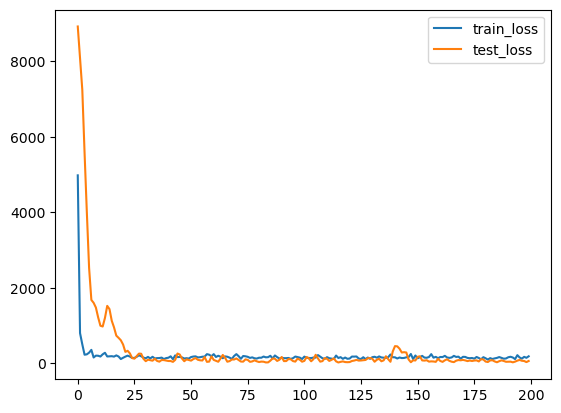

In [13]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0
    
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    
    return train_loss

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0
    
    for i, (data, target) in enumerate(test_loader):
        output = model(data)
        loss = criterion(output, target.float().unsqueeze(1))
        
        running_loss += loss.item()
        
    test_loss = running_loss / len(test_loader)
    
    return test_loss

#Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_loss_list = []
test_loss_list = []

for epoch in range(200):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    print('epoch: {}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch + 1, train_loss, test_loss))
    
#Plot
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.legend()

In [14]:
#Predict
model.eval()
pred = []

for i, (data, target) in enumerate(test_loader):
    output = model(data)
    pred.append(output.detach().numpy())
    

pred = np.concatenate(pred, axis = 0)

In [15]:
pred = pd.DataFrame(pred)
pred = pred[0].values
pred

array([ 67.67948 ,  56.103016,  70.0201  ,  98.93126 ,  97.47215 ,
        60.815197,  70.270874,  89.2669  ,  63.193   , 104.65245 ,
        94.16469 ,  57.470676,  84.89164 ,  58.968933,  76.67074 ,
       105.10272 ,  85.55425 ,  75.93754 ,  61.844055,  83.28737 ,
        68.981285,  59.443714,  78.54593 , 159.3221  ,  47.51677 ,
       146.83766 ,  99.16359 , 101.03311 ,  71.79303 ,  90.37394 ,
        56.56373 ,  67.247284,  67.02121 , 107.117744,  89.75715 ,
        96.238045,  67.26294 , 163.45813 ,  76.01518 ], dtype=float32)

Text(0.5, 1.0, 'RMSE: 6.9489')

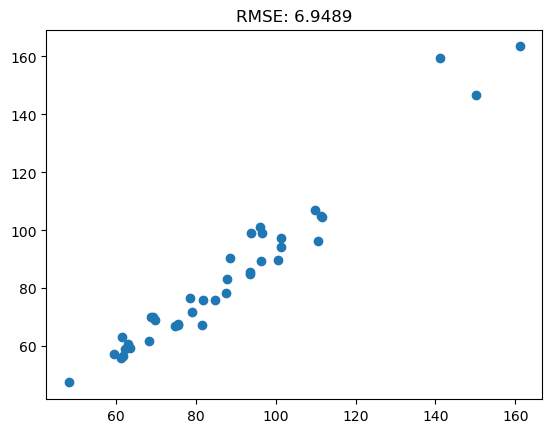

In [16]:
y_test = label[test_idx]
plt.scatter(y_test, pred)
rmse = np.sqrt(np.mean((y_test - pred) ** 2))
plt.title('RMSE: {:.4f}'.format(rmse))